IMPORTING DATA


In [20]:

import os
import glob
import numpy as np
import pandas as pd

# Setup
labels = ['Bearing', 'Flywheel', 'Healthy', 'LIV', 'LOV', 'NRV', 'Piston', 'Riderbelt']
Faults = {label: idx for idx, label in enumerate(labels)}
MaxExpNo = 225

# Base path to dataset
base_path = os.path.expanduser('~/Downloads/AirCompressor_Data')

# Raw data store
raw_data = []  # list of dicts: [{'signal': ndarray, 'label': str, 'fault': int}, ...]

for label in labels:
    path = os.path.join(base_path, label, 'preprocess_Reading*.dat')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"⚠️ No files found for label: {label}")
        continue

    for file in files:
        try:
            signal = np.loadtxt(file, delimiter=',')
            raw_data.append({
                'signal': signal,
                'label': label,
                'fault': Faults[label]
            })
        except Exception as e:
            print(f"❌ Error loading {file}: {e}")

print(f"\n✅ Loaded {len(raw_data)} total files.")



✅ Loaded 1800 total files.


Filtering signal

In [21]:
from scipy.signal import firwin, butter, filtfilt

def filter_signal(signal, Fs):
    """
    Apply fan high-pass FIR filter (400 Hz) and low-pass Butterworth (12 kHz)
    on the raw acoustic signal.
    
    Parameters:
        signal (np.ndarray): Raw time-domain signal.
        Fs (int): Sampling frequency in Hz.
    
    Returns:
        np.ndarray: Filtered signal
    """
    # ---- High-pass FIR (Fan Filter) ----
    cutoff_hp = 400  # 400 Hz fan noise removal
    nyq = Fs / 2
    fir_order = 101  # you can tune this
    hp_fir_coeffs = firwin(fir_order, cutoff_hp / nyq, pass_zero=False)
    signal_hp = filtfilt(hp_fir_coeffs, [1.0], signal)

    # ---- Low-pass Butterworth (Anti-noise Filter) ----
    cutoff_lp = 12000  # 12 kHz noise threshold
    b_lp, a_lp = butter(N=18, Wn=cutoff_lp / nyq, btype='low')
    signal_filtered = filtfilt(b_lp, a_lp, signal_hp)

    return signal_filtered



In [22]:
def clip_signal_by_std(signal, Fs):
    """
    Clip a 5-second signal into 9 overlapping 1-second segments with 50% overlap,
    and return the segment with the minimum standard deviation.
    
    Parameters:
        signal (np.ndarray): Full input signal (should be ~5 sec long)
        Fs (int): Sampling frequency in Hz

    Returns:
        np.ndarray: 1-second clipped segment with minimum standard deviation
    """
    segment_length = Fs  # 1 second = Fs samples
    stride = Fs // 2      # 50% overlap = 0.5 sec stride
    total_segments = 9

    min_std = float('inf')
    best_segment = None

    for i in range(total_segments):
        start = i * stride
        end = start + segment_length

        if end > len(signal):
            break  # avoid out-of-bound

        segment = signal[start:end]
        std = np.std(segment)

        if std < min_std:
            min_std = std
            best_segment = segment

    return best_segment

In [23]:
import numpy as np

def smooth_signal_moving_average(signal, window_size=5):
    """
    Apply a moving average filter to smooth the signal.
    
    Parameters:
        signal (np.ndarray): Input 1D signal
        window_size (int): Half-window size on each side (total window = 2*window_size + 1)
        
    Returns:
        np.ndarray: Smoothed signal
    """
    kernel_size = 2 * window_size + 1
    kernel = np.ones(kernel_size) / kernel_size
    smoothed = np.convolve(signal, kernel, mode='same')  # Keep output length same
    return smoothed


In [24]:
import numpy as np

def modified_minmax_normalization(signal, num_bins=10000, rejection_percent=0.00025):
    """
    Apply modified Min-Max normalization as described in the paper.
    Ignores top/bottom 0.025% of values while computing min/max.
    
    Parameters:
        signal (np.ndarray): Input 1D signal
        num_bins (int): Number of histogram bins (default: 10,000)
        rejection_percent (float): Fraction of data to reject from both ends (default: 0.025%)
        
    Returns:
        np.ndarray: Normalized signal between 0 and 1
    """

    N = len(signal)
    total_reject = int(rejection_percent * N)

    # Build histogram
    hist_counts, bin_edges = np.histogram(signal, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Cumulative count
    cum_counts = np.cumsum(hist_counts)

    # Find mod_min: first bin index after rejecting lower values
    lower_idx = np.searchsorted(cum_counts, total_reject)
    mod_min = bin_centers[lower_idx]

    # Find mod_max: first bin index from top after rejecting upper values
    upper_idx = np.searchsorted(cum_counts, N - total_reject)
    mod_max = bin_centers[upper_idx]

    # Apply modified Min-Max normalization
    clipped = np.clip(signal, mod_min, mod_max)
    normalized = (clipped - mod_min) / (mod_max - mod_min)

    return normalized

In [25]:
for entry in raw_data:
    Fs = 48000
    entry['original_signal'] = entry['signal'].copy()  # store raw

    signal = entry['signal']
    signal = filter_signal(signal, Fs)                             # Step A
    signal = clip_signal_by_std(signal, Fs)                        # Step B
    signal = smooth_signal_moving_average(signal, window_size=5)  # Step C
    signal = modified_minmax_normalization(signal)                # Step D

    entry['signal'] = signal  # store preprocessed


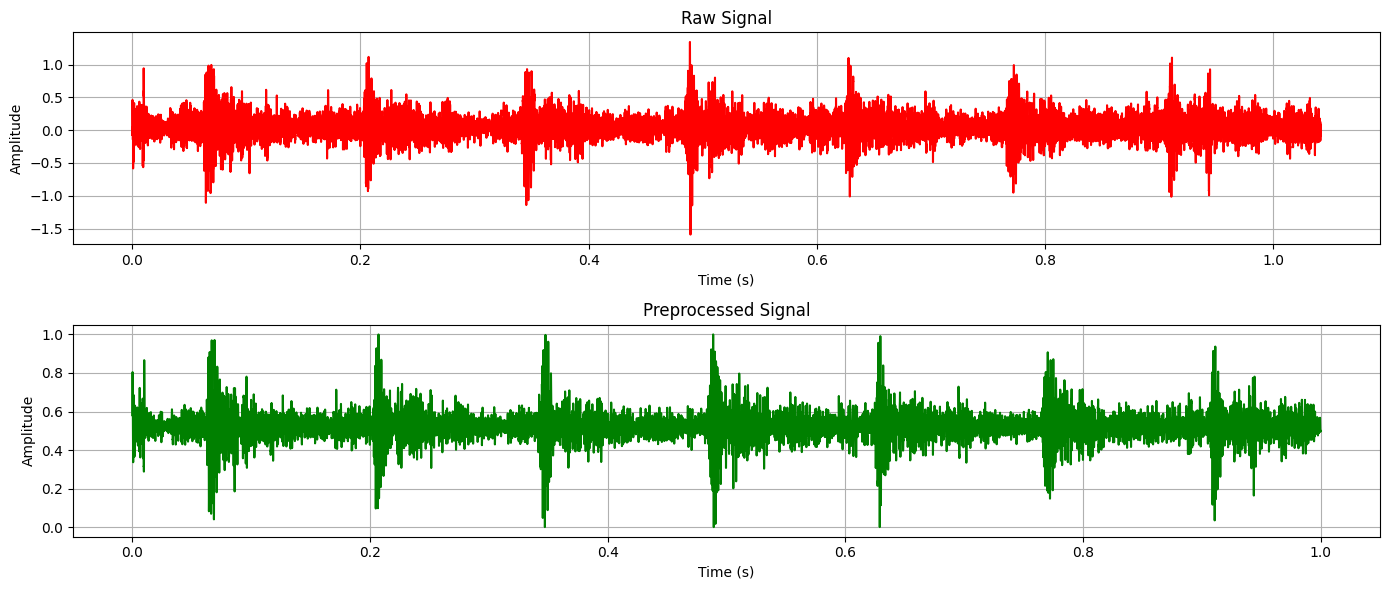

In [26]:
import matplotlib.pyplot as plt
import numpy as np

idx = 0  # or any valid index
raw = raw_data[idx]['original_signal']
processed = raw_data[idx]['signal']
Fs = 48000

t_raw = np.arange(len(raw)) / Fs
t_proc = np.arange(len(processed)) / Fs

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t_raw, raw, color='red')
plt.title('Raw Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_proc, processed, color='green')
plt.title('Preprocessed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()


FEATURE EXTRACTION

## Feature Extraction


In [27]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft
from scipy.signal import fftconvolve
import pywt


#### Time-Domain Features (8)

In [28]:

# --- Feature Extraction Functions ---

def PrimaryFeatureExtractor(X):
    rms = np.sqrt(np.mean(np.square(X)))
    CrestFactor = np.abs(X).max() / rms
    ShapeFactor = rms / np.mean(np.abs(X))
    return [
        np.mean(np.abs(X)),
        np.min(X),
        np.max(X),
        np.std(X),
        rms,
        skew(X),
        kurtosis(X),
        CrestFactor
    ]


#### Frequency-Domain (8 bins)

In [29]:
def FFT_BasedFeatures(X, NBins=8):
    N = len(X)
    X_fft = fft(X)
    X_fft[0] = 0
    X_fft_magnitude = 2.0 / N * np.abs(X_fft[:N // 2])

    bin_size = len(X_fft_magnitude) // NBins
    SpecEnergy = [
        X_fft_magnitude[i * bin_size:(i + 1) * bin_size].sum()
        for i in range(NBins)
    ]

    total_energy = sum(SpecEnergy)
    normalized_features = [e / total_energy for e in SpecEnergy]
    return normalized_features, [f'FFT{i+1}' for i in range(NBins)]



#### Morlet Wavelet Transform (MWT – 7 features)

In [ ]:
def morlet_wavelet(length, w=5.0):
    x = np.linspace(-np.pi, np.pi, length)
    wave = np.exp(1j * w * x) * np.exp(-0.5 * x**2)
    return wave.real

def extract_mwt_features(X):
    widths = np.arange(1, 31)
    wavelets = [morlet_wavelet(len(X), w) for w in widths]
    wavelet_matrix = np.array([fftconvolve(X, w, mode='same') for w in wavelets])
    energy = np.sum(np.abs(wavelet_matrix) ** 2, axis=1)
    prob = energy / (np.sum(energy) + 1e-12)

    return [
        -np.sum(prob * np.log2(prob + 1e-12)),                # Entropy
        np.sum(np.max(wavelet_matrix, axis=1)),               # Sum of Peaks
        np.std(wavelet_matrix),                               # Std
        kurtosis(wavelet_matrix.flatten()),                   # Kurtosis
        np.mean(np.diff(np.sign(wavelet_matrix)) != 0),       # ZCR
        np.var(wavelet_matrix),                               # Variance
        skew(wavelet_matrix.flatten())                        # Skewness
    ]


#### Discrete Wavelet Transform (DWT – 9 features)

In [ ]:
def extract_dwt_features(X):
    coeffs = pywt.wavedec(X, 'db4', level=6)
    details = coeffs[1:]

    var_features = [np.var(d) for d in details[:3]]
    autocorr_var = [np.var(np.correlate(d, d, mode='full')) for d in details[3:6]]
    smoothed_mean = [np.mean(pd.Series(d).rolling(5, min_periods=1).mean()) for d in details[:3]]
    return var_features + autocorr_var + smoothed_mean


#### Wavelet Packet Transform (WPT – 254 features)

In [ ]:
def extract_wpt_features(X):
    wp = pywt.WaveletPacket(data=X, wavelet='db4', mode='symmetric', maxlevel=7)
    nodes = wp.get_level(7, order='freq')
    energies = [np.sum(np.square(n.data)) for n in nodes]
    if len(energies) < 254:
        energies += [0] * (254 - len(energies))
    return energies[:254]


#### Combine All Features


In [ ]:
def extract_all_features(signal):
    stat = PrimaryFeatureExtractor(signal)                 # 8
    fft_feats, _ = FFT_BasedFeatures(signal)               # 8
    mwt = extract_mwt_features(signal)                     # 7
    dwt = extract_dwt_features(signal)                     # 9
    wpt = extract_wpt_features(signal)                     # 254
    return stat + fft_feats + mwt + dwt + wpt


#### Run on Dataset

In [ ]:
feature_rows = []
for idx, entry in enumerate(raw_data):
    try:
        signal = entry['signal']
        fault = entry['fault']
        features = extract_all_features(signal)
        feature_rows.append(features + [fault])
        if idx % 10 == 0:
            print(f"Processed {idx}/{len(raw_data)}")
    except Exception as e:
        print(f"Error at index {idx}: {e}")


Processed 0/1800
Processed 10/1800
Processed 20/1800
Processed 30/1800
Processed 40/1800
Processed 50/1800
Processed 60/1800
Processed 70/1800
Processed 80/1800
Processed 90/1800
Processed 100/1800
Processed 110/1800
Processed 120/1800
Processed 130/1800
Processed 140/1800
Processed 150/1800
Processed 160/1800
Processed 170/1800
Processed 180/1800
Processed 190/1800
Processed 200/1800
Processed 210/1800
Processed 220/1800
Processed 230/1800
Processed 240/1800
Processed 250/1800
Processed 260/1800
Processed 270/1800
Processed 280/1800
Processed 290/1800
Processed 300/1800
Processed 310/1800
Processed 320/1800
Processed 330/1800
Processed 340/1800
Processed 350/1800
Processed 360/1800
Processed 370/1800
Processed 380/1800
Processed 390/1800
Processed 400/1800
Processed 410/1800
Processed 420/1800
Processed 430/1800
Processed 440/1800
Processed 450/1800
Processed 460/1800
Processed 470/1800
Processed 480/1800
Processed 490/1800
Processed 500/1800
Processed 510/1800
Processed 520/1800
Proc

#### Construct DataFrame

In [30]:
# Labels for columns
stat_labels = ['Mean', 'Min', 'Max', 'Std', 'RMS', 'Skewness', 'Kurtosis', 'CrestFactor']
fft_labels = [f'FFT{i+1}' for i in range(8)]
mwt_labels = ['MWT_Entropy', 'MWT_SumPeaks', 'MWT_Std', 'MWT_Kurtosis', 'MWT_ZCR', 'MWT_Variance', 'MWT_Skewness']
dwt_labels = [f'DWT_Var_D{i+1}' for i in range(3)] + \
             [f'DWT_AutoVar_D{i+4}' for i in range(3)] + \
             [f'DWT_SmoothedMean_D{i+1}' for i in range(3)]
wpt_labels = [f'WPT_Node{i+1}' for i in range(254)]

all_columns = stat_labels + fft_labels + mwt_labels + dwt_labels + wpt_labels + ['Fault']
data = pd.DataFrame(feature_rows, columns=all_columns)

input_data = data.drop(columns=['Fault'])
target_data = data[['Fault']].astype(int)

print("Feature extraction complete.")
print(f"input_data shape: {input_data.shape}")
print(f"target_data shape: {target_data.shape}")
input_data.to_csv('input_data.csv', index=False)
target_data.to_csv('target_data.csv', index=False)

NameError: name 'feature_rows' is not defined

In [32]:
#reading from INPUT DATA.CSV
input_data = pd.read_csv("/Users/krishnagarg/EE656-Course-project-4/input_data.csv")
target_data =  pd.read_csv("/Users/krishnagarg/EE656-Course-project-4/target_data.csv") 
print("Feature extraction complete.")
print(f"input_data shape: {input_data.shape}")
print(f"target_data shape: {target_data.shape}")
input_data.to_csv('input_data.csv', index=False)
target_data.to_csv('target_data.csv', index=False)

Feature extraction complete.
input_data shape: (1800, 286)
target_data shape: (1800, 1)


In [33]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

class PCA_Selector:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X, y=None):
        self.pca.fit(X)
        return self

    def transform(self, X):
        return self.pca.transform(X)

    def fit_transform(self, X, y=None):
        return self.pca.fit_transform(X)

# Example usage

y = target_data['Fault'].values.astype(int)
X = input_data.values
pca_selector = PCA_Selector(n_components=2)
X_pca = pca_selector.fit_transform(X)

print("PCA reduced shape:", X_pca.shape)


PCA reduced shape: (1800, 2)


In [34]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class MIFS_Selector:
    def __init__(self, n_features_to_select, beta=0.5, problem_type='classification'):
        self.n_features_to_select = n_features_to_select
        self.beta = beta
        self.problem_type = problem_type
        self.selected_features = []

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Calculate mutual information between each feature and target
        if self.problem_type == 'classification':
            mi_fc = mutual_info_classif(X, y)
        else:
            mi_fc = mutual_info_regression(X, y)

        # Initialize selected features with the one having max MI with target
        selected = [int(np.argmax(mi_fc))]
        remaining = [i for i in range(n_features) if i not in selected]

        while len(selected) < self.n_features_to_select:
            redundancy = np.zeros(len(remaining), dtype=float)

            for i, feat in enumerate(remaining):
                mi_fs = 0.0
                for s in selected:
                    # Compute MI between continuous features (regression)
                    mi_arr = mutual_info_regression(
                        X[:, feat].reshape(-1, 1),
                        X[:, s]
                    )
                    # mutual_info_regression returns an array of length 1
                    mi_fs += float(mi_arr[0])

                # MIFS criterion: relevance minus redundancy
                redundancy[i] = mi_fc[feat] - self.beta * mi_fs

            # Select feature with maximum criterion value
            next_feat = remaining[int(np.argmax(redundancy))]
            selected.append(next_feat)
            remaining.remove(next_feat)

        self.selected_features = selected
        return self

    def transform(self, X):
        return X[:, self.selected_features]

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

# Example usage:
# Ensure y is integer for classification
y = target_data['Fault'].values.astype(int)
X = input_data.values
mifs_selector = MIFS_Selector(n_features_to_select=10, beta=0.7, problem_type='classification')
X_selected = mifs_selector.fit_transform(X, y)
print("Selected features:", mifs_selector.selected_features)

Selected features: [10, 98, 129, 39, 22, 247, 215, 233, 212, 29]


In [35]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class mRMR_Selector(FeatureSelector):
    def __init__(self, n_features_to_select, problem_type='classification'):
        super().__init__(n_features_to_select)
        self.problem_type = problem_type

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.n_features_to_select is None:
            self.n_features_to_select = n_features // 2

        # Calculate MI between each feature and target
        if self.problem_type == 'classification':
            mi_fc = mutual_info_classif(X, y)
        else:
            mi_fc = mutual_info_regression(X, y)

        # Start with the feature having highest relevance
        selected = [int(np.argmax(mi_fc))]
        remaining = [i for i in range(n_features) if i not in selected]

        while len(selected) < self.n_features_to_select:
            scores = np.zeros(len(remaining), dtype=float)

            for idx, feat in enumerate(remaining):
                # compute total redundancy wrt already selected features
                mi_fs = 0.0
                for s in selected:
                    # ALWAYS use regression MI for feature–feature
                    mi_arr = mutual_info_regression(
                        X[:, feat].reshape(-1, 1),
                        X[:, s]
                    )
                    mi_fs += float(mi_arr[0])

                # mRMR score = relevance − (1/|S|)*redundancy
                beta = 1.0 / len(selected)
                scores[idx] = mi_fc[feat] - beta * mi_fs

            # pick the feature with highest mRMR score
            next_feat = remaining[int(np.argmax(scores))]
            selected.append(next_feat)
            remaining.remove(next_feat)

        self.selected_features = selected
        return self

    def transform(self, X):
        return X[:, self.selected_features]

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

# Usage example:
# y = target_data['Fault'].values.astype(int)
mrmr = mRMR_Selector(n_features_to_select=10, problem_type='classification')
X_mrmr = mrmr.fit_transform(X, y)
print("mRMR selected features:", mrmr.selected_features)


mRMR selected features: [10, 98, 129, 39, 102, 34, 41, 121, 99, 126]


In [38]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

class BD_Selector(FeatureSelector):
    def __init__(self, n_features_to_select):
        super().__init__(n_features_to_select)
        self.epsilon = 1e-6  # regularization term to avoid singular matrices

    def _bhattacharyya_distance(self, X1, X2):
        """Calculate Bhattacharyya distance between two classes"""
        mean1, mean2 = np.mean(X1, axis=0), np.mean(X2, axis=0)
        cov1 = np.cov(X1.T) + self.epsilon * np.eye(X1.shape[1])
        cov2 = np.cov(X2.T) + self.epsilon * np.eye(X2.shape[1])

        mean_diff = mean1 - mean2
        mean_cov = (cov1 + cov2) / 2

        # Calculate the first term using pseudo-inverse
        inv_mean_cov = np.linalg.pinv(mean_cov)
        term1 = 0.125 * mean_diff @ inv_mean_cov @ mean_diff.T

        # Calculate the second term
        det1 = np.linalg.det(cov1)
        det2 = np.linalg.det(cov2)
        det_mean = np.linalg.det(mean_cov)
        # ensure positive determinants
        det1 = max(det1, self.epsilon)
        det2 = max(det2, self.epsilon)
        det_mean = max(det_mean, self.epsilon)
        term2 = 0.5 * np.log(det_mean / np.sqrt(det1 * det2))

        return term1 + term2

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.n_features_to_select is None:
            self.n_features_to_select = n_features // 2

        # Convert continuous target to discrete bins for BD calculation
        if len(np.unique(y)) > 10:
            y_binned = pd.cut(y, bins=5, labels=False)
        else:
            y_binned = y

        unique_classes = np.unique(y_binned)
        if len(unique_classes) < 2:
            raise ValueError("Need at least two classes for BD calculation")

        # Calculate pairwise BD for all features
        bd_matrix = np.zeros((n_features, n_features))
        for i in range(n_features):
            for j in range(i+1, n_features):
                bd_sum = 0.0
                for idx1, c1 in enumerate(unique_classes):
                    for c2 in unique_classes[idx1+1:]:
                        X1 = X[y_binned == c1][:, [i, j]]
                        X2 = X[y_binned == c2][:, [i, j]]
                        if X1.shape[0] > 1 and X2.shape[0] > 1:
                            bd_sum += self._bhattacharyya_distance(X1, X2)
                bd_matrix[i, j] = bd_sum
                bd_matrix[j, i] = bd_sum

        # Calculate mean BD for each feature
        mean_bd = np.mean(bd_matrix + bd_matrix.T, axis=1) / 2

        # Select features with highest mean BD
        self.selected_features = list(np.argsort(mean_bd)[-self.n_features_to_select:][::-1])
        return self

    def transform(self, X):
        return X[:, self.selected_features]

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

# Usage:
bd_selector = BD_Selector(n_features_to_select=10)
X_bd = bd_selector.fit_transform(X, y)
print("BD selected features:", bd_selector.selected_features)

BD selected features: [10, 44, 121, 43, 34, 23, 118, 65, 62, 126]


MODEL SELECTION

In [37]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from itertools import combinations
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ========== DDAG Trainer ==========
def train_ddag_classifiers(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    class_pairs = list(combinations(np.unique(y_train), 2))
    classifiers = {}

    for (class1, class2) in class_pairs:
        idx = (y_train == class1) | (y_train == class2)
        X_pair = X_train[idx]
        y_pair = y_train[idx]
        y_binary = (y_pair == class1).astype(int)

        clf = svm.SVC(kernel=kernel, C=C, gamma=gamma)
        clf.fit(X_pair, y_binary)
        classifiers[(class1, class2)] = clf

    return classifiers, sorted(np.unique(y_train))


# ========== DDAG Prediction ==========
def ddag_predict(X_test, classifiers, class_list):
    y_pred = []

    for x in X_test.to_numpy():
        classes = class_list.copy()

        while len(classes) > 1:
            c1 = classes[0]
            c2 = classes[-1]

            key = (c1, c2) if (c1, c2) in classifiers else (c2, c1)
            clf = classifiers[key]
            pred = clf.predict(x.reshape(1, -1))[0]

            if (c1, c2) in classifiers:
                winner = c1 if pred == 1 else c2
            else:
                winner = c2 if pred == 1 else c1

            classes.remove(c1 if winner == c2 else c2)

        y_pred.append(classes[0])

    return np.array(y_pred)


# ========== TRAIN Function ==========
def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0, gamma='scale', strategy='OAO'):
    base_svm = svm.SVC(kernel=kernel, C=C, gamma=gamma, probability=True)

    if strategy.upper() == 'OAO':
        model = OneVsOneClassifier(base_svm)
        model.fit(X_train, y_train.values.ravel())
        return model

    elif strategy.upper() == 'OAA':
        model = OneVsRestClassifier(base_svm)
        model.fit(X_train, y_train.values.ravel())
        return model

    elif strategy.upper() == 'DDAG':
        classifiers, class_list = train_ddag_classifiers(X_train, y_train.values.ravel(), kernel, C, gamma)
        return {"classifiers": classifiers, "class_list": class_list}

    else:
        raise ValueError("Invalid strategy. Use 'OAO', 'OAA', or 'DDAG'.")


# ========== PREDICT Function ==========
def predict_svm_classifier(model, X_test, strategy='OAO'):
    if strategy.upper() == 'DDAG':
        y_pred = ddag_predict(X_test, model["classifiers"], model["class_list"])
    else:
        y_pred = model.predict(X_test)

    return y_pred


# ========== Optional: Evaluate ==========
def evaluate_model(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


In [54]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    input_data, target_data, test_size=0.2, random_state=42, stratify=target_data
)

# Train model
strategy = 'DDAG'  # or 'OAO', 'OAA'
model = train_svm_classifier(X_train, y_train, kernel='rbf', C=10, gamma='scale', strategy=strategy)

# Predict
y_pred = predict_svm_classifier(model, X_test, strategy=strategy)

# Evaluate
evaluate_model(y_test, y_pred)


Accuracy: 0.9888888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.94      0.98      0.96        45
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        45
           6       1.00      0.96      0.98        45
           7       1.00      1.00      1.00        45

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



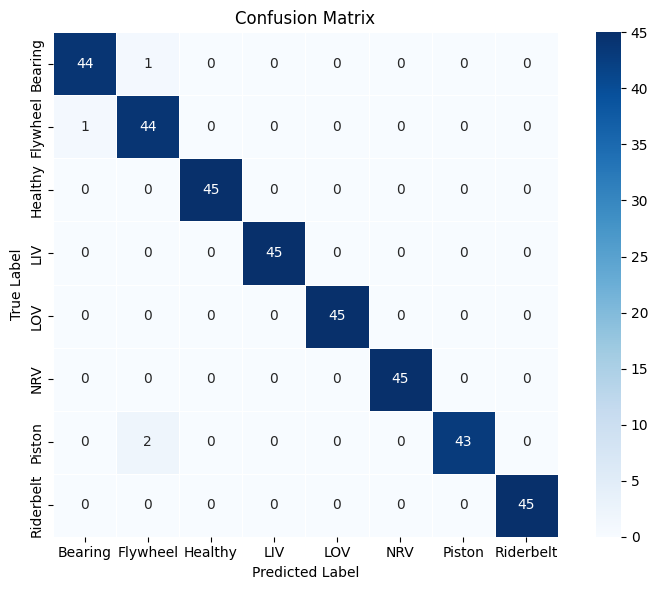

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', linewidths=0.5, square=True)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title + (" (Normalized)" if normalize else ""))
    plt.tight_layout()
    plt.show()


# Predict using your model
y_pred = predict_svm_classifier(model, X_test, strategy=strategy)

# Class names (you already use this order for faults)
class_names = ['Bearing', 'Flywheel', 'Healthy', 'LIV', 'LOV', 'NRV', 'Piston', 'Riderbelt']

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=class_names, normalize=False)


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

# Define the parameter grid using powers of 2
C_range = [2**i for i in range(-2, 13)]         # from 2^-2 to 2^12
gamma_range = [2**i for i in range(-10, 5)]     # from 2^-10 to 2^4

param_grid = {'C': C_range, 'gamma': gamma_range}

# Create SVM with RBF kernel
svm_rbf = SVC(kernel='rbf')

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train.values.ravel())

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best Parameters: {'C': 16, 'gamma': 0.0009765625}
Best Accuracy: 0.9993055555555556
